# Butterfly Image Classification

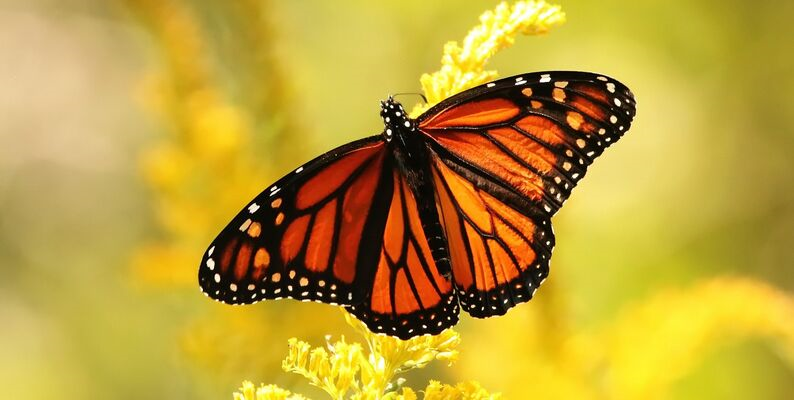

Today, we are going to do some steps to build an Image Classification Model using CNN that identifies the class which each butterfly belongs to:
1. The Data
2. Exploratory Data Analysis
3. Image Preprocessing
4. A basic CNN model
5. Transfer Learning with VGG16

# 1. The Data

The dataset is from [Kaggle - Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) which contains 6499 images belongs to 75 different classes of Butterflies. Each image belongs to only one butterfly category.
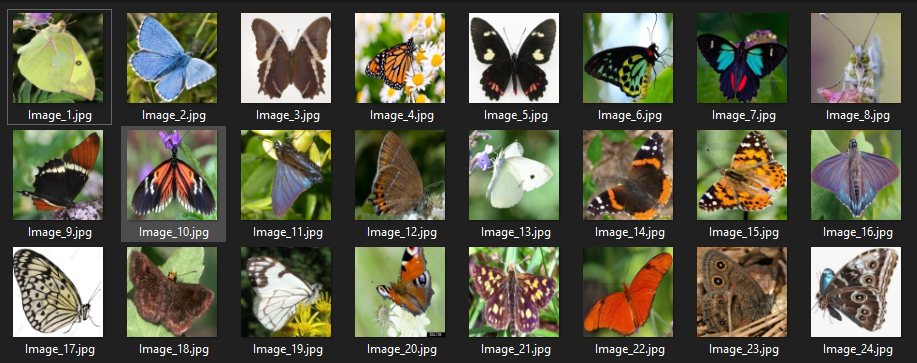

Also we have a csv file that contains label for each butterfly image. We will explore this in the next section.

# 2. Exploratory Data Analysis

**First we will explore the butterfly types from csv file**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random

In [2]:
df = pd.read_csv('Training_set.csv')
df.head(5)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


**Do we have any missing values?**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


**Yeah, we have full data.**

**Next let's check how many types of butterflies we got.**

In [4]:
len(set(df['label']))

75

**75 types as expected.**

**So what about the distribution for each butterfly types? This is so important because we will need a balance dataset for classification problem. Let's figure it out**

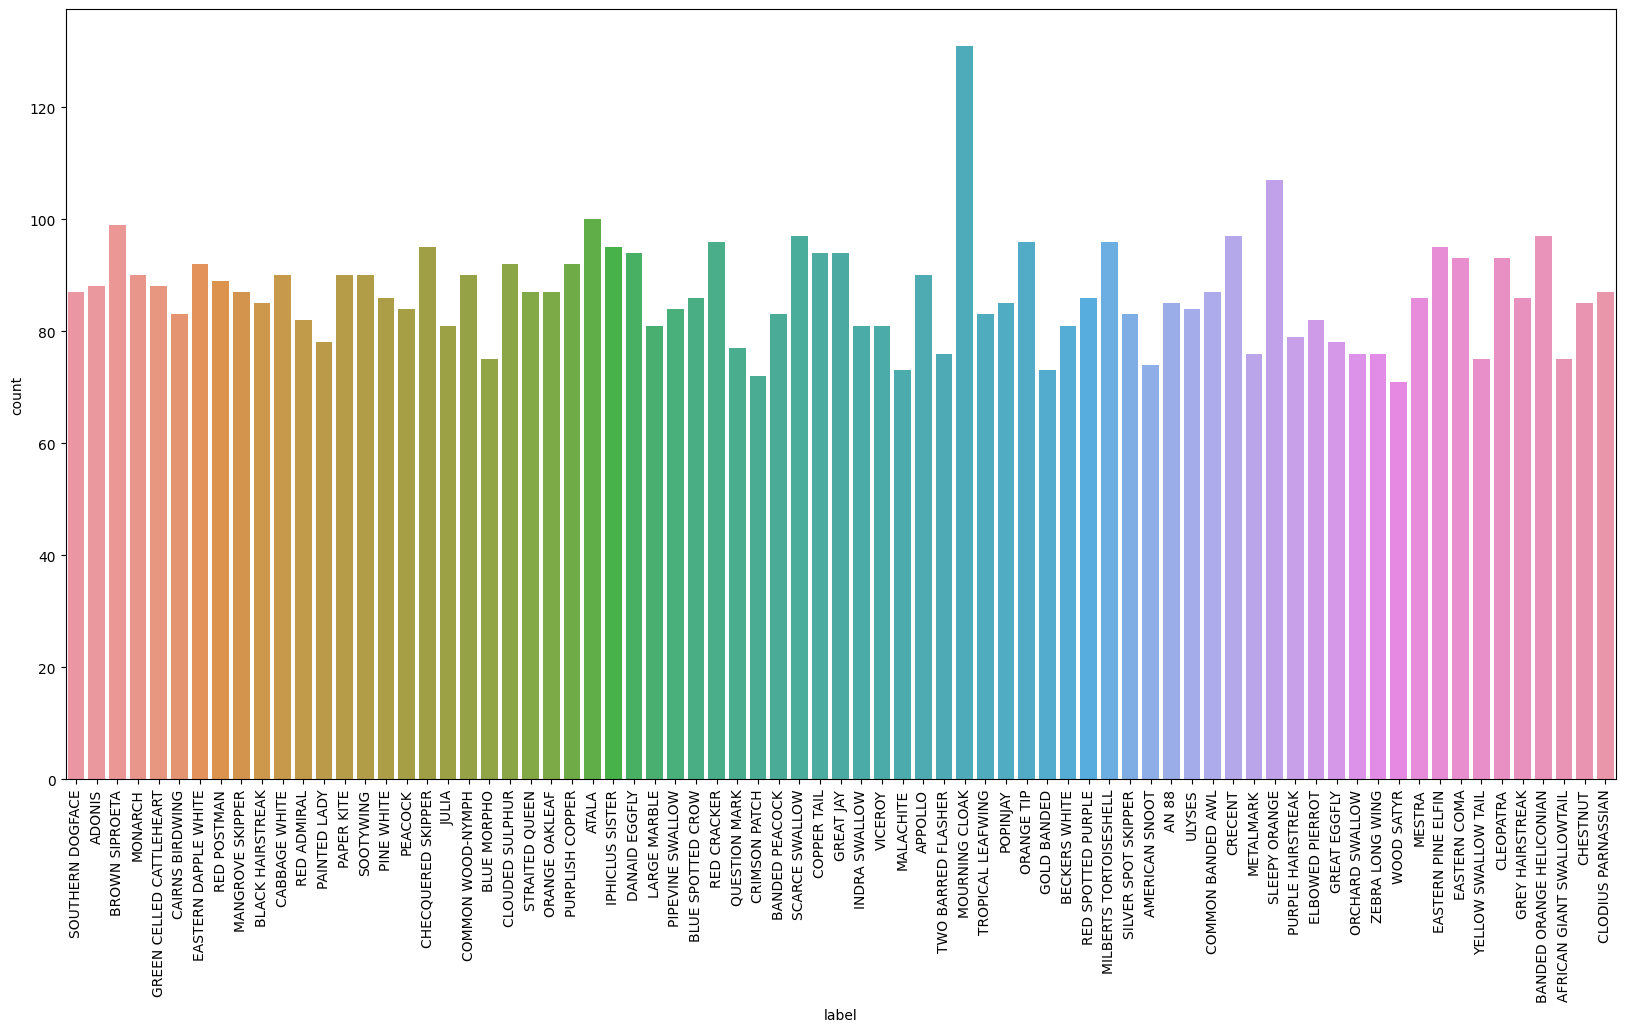

In [8]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, x='label')
plt.show()

**Data seems quite balance, around 80 images for each butterfly class**

**Here are some sample images and its label:**

In [14]:
def show_random_images(folder_path, num_images, df):
    '''
    Show random images from a folder
    
    Input:
        folder_path: folder path
        num_images: number of images we want to display
        df: dataframe containing information of image and its label
    Output:
        None
    '''
    selected_images = random.sample(os.listdir(folder_path), num_images)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 6))

    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(folder_path, image_name)
        image = mpimg.imread(image_path)

        # Display the image
        ax[i].imshow(image)
        ax[i].axis('off')
        
        # Display the image name and label
        label = df.loc[df['filename'] == image_name, 'label'].values[0]
        ax[i].set_title(f'{image_name}\n{label}', fontsize=10)

    plt.tight_layout()
    plt.show()

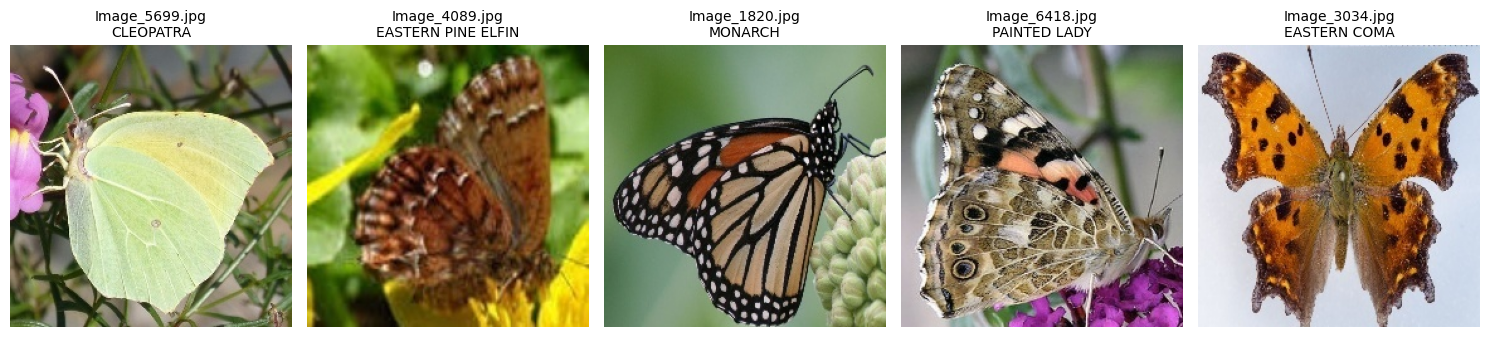

In [12]:
# Run this many times to see different images
show_random_images('train', 5, df)

# 3. Image Preprocessing

**Actually, the dataset is quite good that butterflies are focused and centered in the image. We just do normallize, resize and split data to train and validation/test before fit it to model in the next step.**

For the Image Augmentation (zoom, flip,..) we just left it for now. We can do it to improve model later.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, Layer, BatchNormalization, ReLU, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
# Define data generator for train and test dataset
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

test_generator = datagen.flow_from_dataframe(
    df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.


**OK, now we have a cleaned train (5200 images) and test (1299 images) dataset. Let's go to the next step when we build and evaluate model.**

# 4. A basic CNN model

**Model architecture**

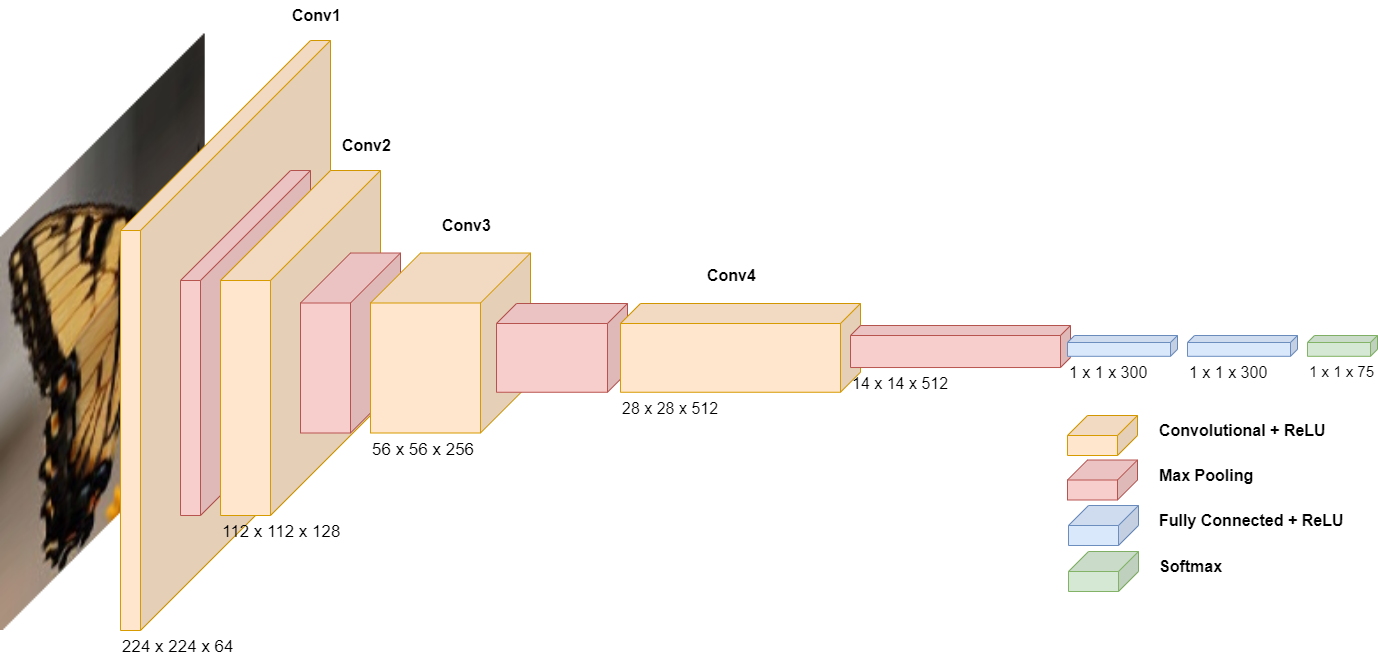

In [19]:
# Create model
def create_model():
    model = Sequential()

    # Convolutional blocks
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(75, activation='softmax'))

    return model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 256)     

In [20]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator
)

Epoch 1/60
163/163 [==============================] - 29s 145ms/step - loss: 4.2963 - accuracy: 0.0204 - val_loss: 4.2671 - val_accuracy: 0.0293
Epoch 2/60
163/163 [==============================] - 21s 126ms/step - loss: 4.2193 - accuracy: 0.0242 - val_loss: 4.1578 - val_accuracy: 0.0362
Epoch 3/60
163/163 [==============================] - 21s 126ms/step - loss: 4.0747 - accuracy: 0.0321 - val_loss: 3.9432 - val_accuracy: 0.0362
Epoch 4/60
163/163 [==============================] - 21s 127ms/step - loss: 3.9558 - accuracy: 0.0315 - val_loss: 3.8353 - val_accuracy: 0.0585
Epoch 5/60
163/163 [==============================] - 21s 127ms/step - loss: 3.8611 - accuracy: 0.0352 - val_loss: 3.7289 - val_accuracy: 0.0662
Epoch 6/60
163/163 [==============================] - 21s 127ms/step - loss: 3.7326 - accuracy: 0.0533 - val_loss: 3.5746 - val_accuracy: 0.0847
Epoch 7/60
163/163 [==============================] - 21s 126ms/step - loss: 3.5893 - accuracy: 0.0715 - val_loss: 3.4904 - val_ac

163/163 [==============================] - 21s 128ms/step - loss: 0.2653 - accuracy: 0.9158 - val_loss: 0.9590 - val_accuracy: 0.7752
Epoch 58/60
163/163 [==============================] - 21s 128ms/step - loss: 0.2681 - accuracy: 0.9131 - val_loss: 1.0071 - val_accuracy: 0.7829
Epoch 59/60
163/163 [==============================] - 21s 128ms/step - loss: 0.2298 - accuracy: 0.9242 - val_loss: 1.0753 - val_accuracy: 0.7783
Epoch 60/60
163/163 [==============================] - 21s 128ms/step - loss: 0.2091 - accuracy: 0.9292 - val_loss: 1.1399 - val_accuracy: 0.7744


**After 60 epochs, the training accuracy is around 90% and validation/test accuracy is around 80%.**

**Training history:**

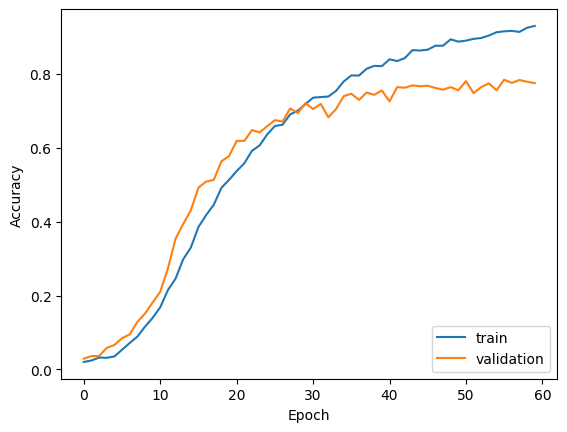

In [21]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# 5. Transfer Learning with VGG16

**In this section we will be using pre-trained model VGG16**

In [10]:
# VGG16
from tensorflow.keras.applications import VGG16

In [11]:
# Create model using VGG16
def create_pretrained_model():
    pretrained_model = Sequential()
    pretrained_model.add(VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3))))
    for layer in pretrained_model.layers:
        layer.trainable = False
        
    pretrained_model.add(GlobalAveragePooling2D())

    pretrained_model.add(Dense(75, activation='softmax'))
    return pretrained_model

pretrained_model = create_pretrained_model()
pretrained_model.summary()

58889256/58889256 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 75)                38475     
                                                                 
Total params: 14,753,163
Trainable params: 38,475
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
# Compile the model
pretrained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = pretrained_model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator
)

Epoch 1/60
163/163 [==============================] - 44s 228ms/step - loss: 4.0875 - accuracy: 0.1104 - val_loss: 3.7788 - val_accuracy: 0.2471
Epoch 2/60
163/163 [==============================] - 29s 179ms/step - loss: 3.5137 - accuracy: 0.3600 - val_loss: 3.3227 - val_accuracy: 0.3741
Epoch 3/60
163/163 [==============================] - 29s 180ms/step - loss: 3.0767 - accuracy: 0.4965 - val_loss: 2.9418 - val_accuracy: 0.5081
Epoch 4/60
163/163 [==============================] - 29s 180ms/step - loss: 2.7224 - accuracy: 0.5779 - val_loss: 2.6531 - val_accuracy: 0.5635
Epoch 5/60
163/163 [==============================] - 29s 180ms/step - loss: 2.4370 - accuracy: 0.6431 - val_loss: 2.3965 - val_accuracy: 0.6289
Epoch 6/60
163/163 [==============================] - 30s 181ms/step - loss: 2.2050 - accuracy: 0.6690 - val_loss: 2.2099 - val_accuracy: 0.6474
Epoch 7/60
163/163 [==============================] - 30s 181ms/step - loss: 2.0090 - accuracy: 0.7088 - val_loss: 2.0457 - val_ac

163/163 [==============================] - 30s 182ms/step - loss: 0.3714 - accuracy: 0.9429 - val_loss: 0.7471 - val_accuracy: 0.8222
Epoch 58/60
163/163 [==============================] - 30s 182ms/step - loss: 0.3651 - accuracy: 0.9450 - val_loss: 0.7402 - val_accuracy: 0.8253
Epoch 59/60
163/163 [==============================] - 30s 182ms/step - loss: 0.3562 - accuracy: 0.9496 - val_loss: 0.7360 - val_accuracy: 0.8229
Epoch 60/60
163/163 [==============================] - 30s 182ms/step - loss: 0.3507 - accuracy: 0.9487 - val_loss: 0.7317 - val_accuracy: 0.8229


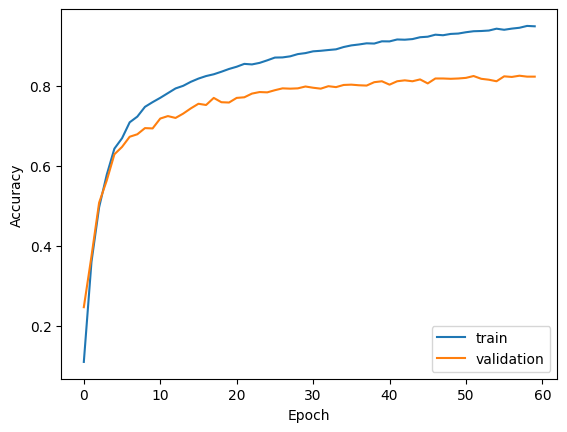

In [13]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

**After 60 epochs, the training accuracy is around 94% and validation/test accuracy is around 82%. The pre-trained model often yields better result.**